# **Basic Operations of Convolutional Neural Networks (CNNs/ConvNets)**:

Although quite similar to each other, ConvNets are different architecturally. ConvNets specifically assume that they're receiving an image as an input with 3D volume of neurons. In other words, the input layer accepts a vector of `Width`, `Height` & `Depth` units of the image.

The ConvNet contains a sequence of layers & each layer transforms a volume of activations through a differentiable function. Generally, a model architecture would've the following layers sequencially laid beside one-another:

1. `INPUT[W x H x D]` layer which holds the raw pixels values of an image with image _width of `W`_, _height of `H`_ & _3 colour channels of `R,G,B`_.

2. The `CONV` layer computes the output of the neurons that are connected to certain local regions of the input which results in a volume of `[W x H x F]` where `F` is the number of filters.

3. The `RELU` layer while leaving the size of the volume unchanged activates certain areas of the input, elementwise.

4. The `POOL` layer performs a downsampling of the input.

5. The `FC` layer computes the class layers with the volume size represented as `[W x H x C]` where C represents the classes.

### **The Convolutional Layer**

 - The core building block of the Neural Net doing most of the computational heavy lifting.

 - The learnable parameters of the Convolutional layer consists of a set of spatial filters extending through the whole depth of the input image.

 - The process of convolution involves performing a dot product of the entries from the filter & the input image, creating a 2-D activational map at every spatial position of the filter. 

 - The network learns those filters that activate based on some kind of visual feature. Hence, accordingly the entire set of filters in each `CONV` layer producing a 2-D output stacked up on each other.

 - Summary of a `CONV` layer:
    
    1. Accepts a volume of size `W x H x D`.

    2. Requires 4 hyperparameters.

        i. Number of filters, `K`.

        ii. Their spatial extent `F`.

        iii. The Stride, `S`.

        iv. The Amount of Zero-Padding, `P`.

    3. Produces a volume of size `W2 × H2 × D2` where:

        - `W2 = (W1−F+2P)/S+1`

        - `H2 = (H1−F+2P)/S+1` (i.e. width and height are computed equally by symmetry)

        - `D2 = K`

    4. With parameter sharing, it introduces `F⋅F⋅D1` weights per filter, for a total of `(F⋅F⋅D1)⋅K` weights and `K` biases.

    5. In the output volume, the _d_-th depth slice (of size `W2×H2`) is the result of performing a valid convolution of the d-th filter over the input volume with a stride of `S`, and then offset by _d_-th bias.

### **The Pooling Layer**:

A pooling layer is periodically inserted to function as a spatial size reducer of the representation so that the number of parameters can be brought down significantly. This helps in preventing overfitting as well as lesser strain on the computation process.

Generally, the _Pooling layer_ does:

1. Accepts a volume of size `W × H × D`.

2. Requires two hyperparameters:

    - Their spatial extent, `F`.
    
    - The stride, `S`.

3. Produces a volume of size `W2 × H2 × D2`, where:

    - `W2 = (W−F)/S+1`

    - `H2 = (H−F)/S+1`

    - `D2 = D`

4. Introduces zero parameters since it computes a fixed function of the input

5. For Pooling layers, it is not common to pad the input using zero-padding.

### **Some More Information On Layers**:

- _Normalization layers_

- _Fully-Connected (FC) layers_

- _Converted FC layers to Conv layers_

- General pattern of stacked layers look like:

    ```
    INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC
    ```
    
    where, the `*` indicates repetition, and the `POOL?` indicates an optional pooling layer. Moreover, `N >= 0` (and usually `N <= 3`), `M >= 0`, `K >= 0` (and usually `K < 3`).

- Layer Sizing pattern

    1. The `INPUT` layer should be divisible by 2 many times over & some common numbers iclude - `32`, `64`, `96`, `224`, `384`, `512`.

    2. The `CONV` layers should be zero-padded properly such that the original spatial dimemsions are intact. Also small filters like `3x3` or `5x5` should be used with stride = 1.

    3. The `POOL` layers are responsible for downsampling the spatial dimensions by using a maxpooling of 2x2 receptive fields.

**_Resources_**:

1. Perhaps the most comprehensive & informative piece is the official [CS231n Convolutional Neural Network for Visual Recognition](https://cs231n.github.io/convolutional-networks/#overview) course website from Stanford. Highly recommend & almost answers everything about the topic.

2. [A Gentle Introduction to Pooling Layers for Convolutional Neural Networks](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/)

3. [Intuitively Understanding Convolutions for Deep Learning](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1) visually appealing & brief enough to grasp the concepts quickly.

4. Analogical example of the article - [Understanding Convolutions](https://colah.github.io/posts/2014-07-Understanding-Convolutions/) has good visual descriptions alongwith examples.

# Building & Training A ConvNet/CNN in TensorFlow & Keras

### Preparing the Data

In [0]:
import tensorflow as tf

In [0]:
num_classes = 10
img_rows, img_cols, img_ch = 28, 28, 1
input_shape = (img_rows, img_cols, img_ch)

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0


x_train = x_train.reshape(x_train.shape[0], *input_shape)
x_test = x_test.reshape(x_test.shape[0], *input_shape)

11493376/11490434 [==============================] - 0s 0us/step


### Simple Convolutional layer to be Used inside a ConvNet

In [0]:
class SimpleConvolutionLayer(tf.keras.layers.Layer):

    def __init__(self, num_kernels=32, kernel_size=(3, 3), strides=(1, 1), use_bias=True):
        """
        Initialize the layer.
        :param num_kernels:     Number of kernels for the convolution
        :param kernel_size:     Kernel size (H x W)
        :param strides:         Vertical and horizontal stride as list
        :param use_bias:        Flag to add a bias after covolution / before activation
        """
        # First, we have to call the `Layer` super __init__(), as it initializes hidden mechanisms:
        super().__init__()  
        # Then we assign the parameters:
        self.num_kernels = num_kernels
        self.kernel_size = kernel_size
        self.strides = strides
        self.use_bias = use_bias

    def build(self, input_shape):
        """
        Build the layer, initializing its parameters according to the input shape.
        This function will be internally called the first time the layer is used, though
        it can also be manually called.
        :param input_shape:     Input shape the layer will receive (e.g. B x H x W x C)
        """
        # We are provided with the input shape here, so we know the number of input channels:
        num_input_channels = input_shape[-1]  # assuming shape format BHWC

        # Now we know how the shape of the tensor representing the kernels should be:
        kernels_shape = (*self.kernel_size, num_input_channels, self.num_kernels)

        # For this example, we initialize the filters with values picked from a Glorot distribution:
        glorot_uni_initializer = tf.initializers.GlorotUniform()
        self.kernels = self.add_weight(name='kernels',
                                       shape=kernels_shape,
                                       initializer=glorot_uni_initializer,
                                       trainable=True)  # and we make the variable trainable.

        if self.use_bias:  # If bias should be added, we initialize its variable too:
            self.bias = self.add_weight(name='bias',
                                        shape=(self.num_kernels,),
                                        initializer='random_normal',  # e.g., using normal distribution.
                                        trainable=True)

    def call(self, inputs):
        """
        Call the layer and perform its operations on the input tensors
        :param inputs:  Input tensor
        :return:        Output tensor
        """
        # We perform the convolution:
        z = tf.nn.conv2d(inputs, self.kernels, strides=[1, *self.strides, 1], padding='VALID')

        if self.use_bias:  # we add the bias if requested:
            z = z + self.bias
        # Finally, we apply the activation function (e.g. ReLU):
        return tf.nn.relu(z)

    def get_config(self):
        """
        Helper function to define the layer and its parameters.
        :return:        Dictionary containing the layer's configuration
        """
        return {'num_kernels': self.num_kernels,
                'kernel_size': self.kernel_size,
                'strides': self.strides,
                'use_bias': self.use_bias}

### Recommended Way of Building a ConvNet

In [0]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [0]:
class LeNet5(Model):
    
    def __init__(self, num_classes):
        """
        Initialize the model.
        :param num_classes:     Number of classes to predict from
        """
        super(LeNet5, self).__init__()
        # We instantiate the various layers composing LeNet-5:
        # self.conv1 = SimpleConvolutionLayer(6, kernel_size=(5, 5))
        # self.conv2 = SimpleConvolutionLayer(16, kernel_size=(5, 5))
        # ... or using the existing and (recommended) Conv2D class:
        self.conv1 = Conv2D(6, kernel_size=(5, 5), padding='same', activation='relu')
        self.conv2 = Conv2D(16, kernel_size=(5, 5), activation='relu')
        self.max_pool = MaxPooling2D(pool_size=(2, 2))
        self.flatten = Flatten()
        self.dense1 = Dense(120, activation='relu')
        self.dense2 = Dense(84, activation='relu')
        self.dense3 = Dense(num_classes, activation='softmax')
        
    def call(self, inputs):
        """
        Call the layers and perform their operations on the input tensors
        :param inputs:  Input tensor
        :return:        Output tensor
        """
        x = self.max_pool(self.conv1(inputs))        # 1st block
        x = self.max_pool(self.conv2(x))             # 2nd block
        x = self.flatten(x)
        x = self.dense3(self.dense2(self.dense1(x))) # dense layers
        return x

### Training & Classifying MNIST Dataset.

In [0]:
model = LeNet5(num_classes)
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
# We can call `model.summary()` only if the model was built before. 
# It is normally done automatically at the first use of the network,
# inferring the input shapes from the samples the network is given.
# For instance, the command below would build the network (then use it for prediction):
_ = model.predict(x_test[:10])

# But we can build the model manually otherwise, providing the batched
# input shape ourselves:
batched_input_shape = tf.TensorShape((None, *input_shape))
model.build(input_shape=batched_input_shape)

# Method to visualize the architecture of the network:
model.summary()

Model: "le_net5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  156       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  2416      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  48120     
_________________________________________________________________
dense_1 (Dense)              multiple                  10164     
_________________________________________________________________
dense_2 (Dense)              multiple                  850 

In [0]:
callbacks = [
    # Callback to interrupt the training if the validation loss (`val_loss`) stops improving for over 3 epochs:
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    # Callback to log the graph, losses and metrics into TensorBoard (saving log files in `./logs` directory):
    tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True)]

In [11]:
history = model.fit(x_train, y_train,
                    batch_size=32, epochs=80, validation_data=(x_test, y_test), 
                    verbose=1,  # change to `verbose=1` to get a progress bar
                                # (we opt for `verbose=2` here to reduce the log size)
                    callbacks=callbacks)

Epoch 1/80
1875/1875 [==============================] - 42s 22ms/step - loss: 0.1304 - accuracy: 0.9610 - val_loss: 0.0850 - val_accuracy: 0.9746
Epoch 2/80
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0888 - accuracy: 0.9721 - val_loss: 0.0716 - val_accuracy: 0.9776
Epoch 3/80
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0703 - accuracy: 0.9783 - val_loss: 0.0581 - val_accuracy: 0.9810
Epoch 4/80
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0600 - accuracy: 0.9813 - val_loss: 0.0494 - val_accuracy: 0.9831
Epoch 5/80
1875/1875 [==============================] - 42s 22ms/step - loss: 0.0527 - accuracy: 0.9835 - val_loss: 0.0480 - val_accuracy: 0.9840
Epoch 6/80
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0470 - accuracy: 0.9850 - val_loss: 0.0420 - val_accuracy: 0.9857
Epoch 7/80
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0422 - accuracy: 0.9869 - val_loss: 0.0481 -

# Experimenting with Advanced Optimizers

**Resources**:

- [cs231n - Optimization: Stochastic Gradient Descent](https://cs231n.github.io/optimization-1/)

- [An overview of gradient descent optimization algorithms](https://ruder.io/optimizing-gradient-descent/)

In [0]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

In [0]:
def lenet(name='lenet'):
    model = Sequential(name=name)
    # 1st block:
    model.add(Conv2D(6, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # 2nd block:
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Dense layers:
    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [0]:
# Setting some variables to format the logs:
log_begin_red, log_begin_blue, log_begin_green = '\033[91m', '\n\033[94m', '\033[92m'
log_begin_bold, log_begin_underline = '\033[1m', '\033[4m'
log_end_format = '\033[0m'

In [0]:
optimizers_examples = {
    'sgd': optimizers.SGD(),
    'momentum': optimizers.SGD(momentum=0.9),
    'nag': optimizers.SGD(momentum=0.9, nesterov=True),
    'adagrad': optimizers.Adagrad(),
    'adadelta': optimizers.Adadelta(),
    'rmsprop': optimizers.RMSprop(),
    'adam': optimizers.Adam()
}

In [10]:
history_per_optimizer = dict()

print(f"Experiment: {log_begin_red}start{log_end_format} (training logs = off)")
for optimizer_name in optimizers_examples:
    # Resetting the seeds (for random number generation), 
    # to reduce the impact of randomness on the comparison:
    tf.random.set_seed(42)
    np.random.seed(42)
    # Creating the model:
    model = lenet(f"lenet_{optimizer_name}")
    optimizer = optimizers_examples[optimizer_name]
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    # Launching the training (we set `verbose=0`, so the training won't generate any logs):
    print(f"\t> Training with {optimizer_name}: {log_begin_red}start{log_end_format}")
    history = model.fit(x_train, y_train,
                        batch_size=32, epochs=20, validation_data=(x_test, y_test),
                        verbose=0)
    history_per_optimizer[optimizer_name] = history
    print(f'\t> Training with {optimizer_name}: {log_begin_green}done{log_end_format}.')
print(f"Experiment: {log_begin_green}done{log_end_format}")

Experiment: start (training logs = off)
	> Training with sgd: start
	> Training with sgd: done.
	> Training with momentum: start
	> Training with momentum: done.
	> Training with nag: start
	> Training with nag: done.
	> Training with adagrad: start
	> Training with adagrad: done.
	> Training with adadelta: start
	> Training with adadelta: done.
	> Training with rmsprop: start
	> Training with rmsprop: done.
	> Training with adam: start
	> Training with adam: done.
Experiment: done


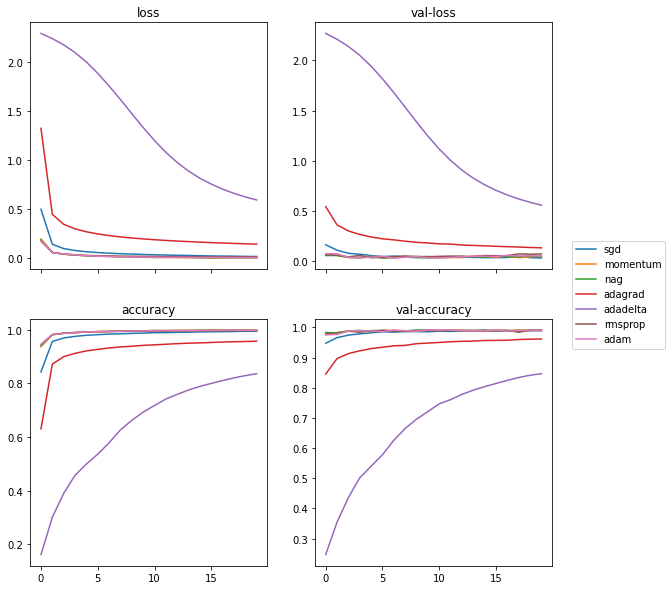

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(10,10), sharex='col')
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("accuracy")
ax[1, 1].set_title("val-accuracy")

lines, labels = [], []
for optimizer_name in history_per_optimizer:
    history = history_per_optimizer[optimizer_name]
    ax[0, 0].plot(history.history['loss'])
    ax[0, 1].plot(history.history['val_loss'])
    ax[1, 0].plot(history.history['accuracy'])
    line = ax[1, 1].plot(history.history['val_accuracy'])
    lines.append(line[0])
    labels.append(optimizer_name)

fig.legend(lines,labels, loc='center right', borderaxespad=0.1)
plt.subplots_adjust(right=0.85)

# Applying Regularization Methods to CNN

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

import os
# Choosing which GPU this notebook can access
# (useful when running multiple experiments in parallel, on different GPUs):
os.environ["CUDA_VISIBLE_DEVICES"]= "1" 

# Defining the seed for some random operations:
random_seed = 42

# Setting some variables to format the logs:
log_begin_red, log_begin_blue, log_begin_green = '\033[91m', '\033[94m', '\033[92m'
log_begin_bold, log_begin_underline = '\033[1m', '\033[4m'
log_end_format = '\033[0m'

In [0]:
num_classes = 10
img_rows, img_cols, img_ch = 28, 28, 1
input_shape = (img_rows, img_cols, img_ch)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(x_train.shape[0], *input_shape)
x_test = x_test.reshape(x_test.shape[0], *input_shape)

In [15]:
# ... 200 training samples instead of 60,000...
x_train, y_train = x_train[:200], y_train[:200]

print(f'Training data: {x_train.shape}')
print(f'Testing data: {x_test.shape}')

Training data: (200, 28, 28, 1)
Testing data: (10000, 28, 28, 1)


In [0]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, Activation, Dense, Flatten, Conv2D, 
                                     MaxPooling2D, Dropout, BatchNormalization)

epochs      = 200
batch_size  = 32

In [0]:
@tf.function
def conv_layer(x, kernels, bias, s):
    z = tf.nn.conv2d(x, kernels, strides=[1,s,s,1], padding='VALID')
    # Finally, applying the bias and activation function (e.g. ReLU):
    return tf.nn.relu(z + bias)


class SimpleConvolutionLayer(tf.keras.layers.Layer):
    def __init__(self, num_kernels=32, kernel_size=(3, 3), stride=1):
        """ Initialize the layer.
        :param num_kernels: Number of kernels for the convolution
        :param kernel_size: Kernel size (H x W)
        :param stride: Vertical/horizontal stride
        """
        super().__init__() 
        self.num_kernels = num_kernels
        self.kernel_size = kernel_size
        self.stride = stride

    def build(self, input_shape):
        """ Build the layer, initializing its parameters.
        This will be internally called the 1st time the layer is used.
        :param input_shape: Input shape for the layer (e.g. BxHxWxC)
        """
        num_input_ch = input_shape[-1] # assuming shape format BHWC
        # Now we know the shape of the kernel tensor we need:
        kernels_shape = (*self.kernel_size, num_input_ch, self.num_kernels)
        # We initialize the filter values e.g. from a Glorot distribution:
        glorot_init = tf.initializers.GlorotUniform()
        self.kernels = self.add_weight( # method to add Variables to layer
            name='kernels', shape=kernels_shape, initializer=glorot_init,
            trainable=True) # and we make it trainable.
        # Same for the bias variable (e.g. from a normal distribution):
        self.bias = self.add_weight(
            name='bias', shape=(self.num_kernels,), 
            initializer='random_normal', trainable=True)

    def call(self, inputs):
        """ Call the layer, apply its operations to the input tensor."""
        return conv_layer(inputs, self.kernels, self.bias, self.stride)

    def get_config(self):
        """
        Helper function to define the layer and its parameters.
        :return:        Dictionary containing the layer's configuration
        """
        return {'num_kernels': self.num_kernels,
                'kernel_size': self.kernel_size,
                'strides': self.strides,
                'use_bias': self.use_bias}

In [0]:
from functools import partial

def l2_reg(coef=1e-2):
    """
    Returns a function computing a weighed L2 norm of a given tensor.
    (this is basically a reimplementation of f.keras.regularizers.l2())
    :param coef:    Weight for the norm
    :return:        Loss function
    """
    return lambda x: tf.reduce_sum(x ** 2) * coef

    
class ConvWithRegularizers(SimpleConvolutionLayer):
    def __init__(self, num_kernels=32, kernel_size=(3, 3), stride=1,
                 kernel_regularizer=l2_reg(), bias_regularizer=None):
        """ 
        Initialize the layer.
        :param num_kernels:        Number of kernels for the convolution
        :param kernel_size:        Kernel size (H x W)
        :param stride:             Vertical/horizontal stride
        :param kernel_regularizer: (opt.) Regularization loss for the kernel variable
        :param bias_regularizer:   (opt.) Regularization loss for the bias variable
        """
        super().__init__(num_kernels, kernel_size, stride)  
        self.kernel_regularizer = kernel_regularizer
        self.bias_regularizer = bias_regularizer

    def build(self, input_shape):
        """
        Build the layer, initializing its components.
        """
        super().build(input_shape)
        # Attaching the regularization losses to the variables.
        if self.kernel_regularizer is not None:
            self.add_loss(partial(self.kernel_regularizer, self.kernels))
        if self.bias_regularizer is not None:
            self.add_loss(partial(self.bias_regularizer, self.bias))

In [19]:
conv = ConvWithRegularizers(num_kernels=32, kernel_size=(3, 3), stride=1,
                            kernel_regularizer=l2_reg(1.), bias_regularizer=l2_reg(1.))
conv.build(input_shape=tf.TensorShape((None, 28, 28, 1)))

# Fetching the layer's losses:
reg_losses = conv.losses
print('Regularization losses over kernel and bias parameters: {}'.format(
    [loss.numpy() for loss in reg_losses]))

# Comparing with the L2 norms of its kernel and bias tensors:
kernel_norm, bias_norm = tf.reduce_sum(conv.kernels ** 2).numpy(), tf.reduce_sum(conv.bias ** 2).numpy()
print(f'L2 norms of kernel and bias parameters: {[kernel_norm, bias_norm]}')

Regularization losses over kernel and bias parameters: [1.9315437, 0.09195678]
L2 norms of kernel and bias parameters: [1.9315437, 0.09195678]


In [21]:
model = Sequential([
    Input(shape=input_shape),
    ConvWithRegularizers(kernel_regularizer=l2_reg(1.), bias_regularizer=l2_reg(1.)),
    ConvWithRegularizers(kernel_regularizer=l2_reg(1.), bias_regularizer=l2_reg(1.)),
    ConvWithRegularizers(kernel_regularizer=l2_reg(1.), bias_regularizer=l2_reg(1.))  
])

print(f'Losses attached to the model and its layers:\n\r{[loss.numpy() for loss in model.losses]} ({len(model.losses)} losses)')

Losses attached to the model and its layers:
[1.8989518, 0.06888567, 32.267693, 0.08637072, 32.053787, 0.06604845] (6 losses)


In [0]:
class LeNet5(Model): # `Model` has the same API as `Layer` + extends it
    
    def __init__(self, num_classes,
                 kernel_regularizer=l2_reg(), bias_regularizer=l2_reg()):
        # Create the model and its layers:
        super(LeNet5, self).__init__()
        self.conv1 = ConvWithRegularizers(
            6, kernel_size=(5, 5), 
            kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)
        self.conv2 = ConvWithRegularizers(
            16, kernel_size=(5, 5),
            kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)
        self.max_pool = MaxPooling2D(pool_size=(2, 2))
        self.flatten = Flatten()
        self.dense1 = Dense(120, activation='relu')
        self.dense2 = Dense(84, activation='relu')
        self.dense3 = Dense(num_classes, activation='softmax')
        
    def call(self, x): # Apply the layers in order to process the inputs
        x = self.max_pool(self.conv1(x)) # 1st block
        x = self.max_pool(self.conv2(x)) # 2nd block
        x = self.flatten(x)
        x = self.dense3(self.dense2(self.dense1(x))) # dense layers
        return x

In [25]:
optimizer  = tf.optimizers.SGD()
dataset    = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
log_string_template = 'Epoch {0:3}/{1}: main loss = {5}{2:5.3f}{6}; ' + \
                      'reg loss = {5}{3:5.3f}{6}; val acc = {5}{4:5.3f}%{6}'

def train_classifier_on_mnist(model, log_frequency=10):

    avg_main_loss = tf.keras.metrics.Mean(name='avg_main_loss', dtype=tf.float32)
    avg_reg_loss  = tf.keras.metrics.Mean(name='avg_reg_loss', dtype=tf.float32)

    print(f"Training: {log_begin_red}start{log_end_format}")
    for epoch in range(epochs):
        for (batch_images, batch_gts) in dataset:    # For each batch of this epoch

            with tf.GradientTape() as grad_tape:     # Tell TF to tape the gradients
                y = model(batch_images)              # Feed forward
                main_loss = tf.losses.sparse_categorical_crossentropy(
                    batch_gts, y)                    # Compute loss
                reg_loss = sum(model.losses)         # List and add other losses
                loss = main_loss + reg_loss

            # Get the gradients of combined losses and back-propagate:
            grads = grad_tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Keep track of losses for display:
            avg_main_loss.update_state(main_loss)
            avg_reg_loss.update_state(reg_loss)

        if epoch % log_frequency == 0 or epoch == (epochs - 1): # Log some metrics
            # Validate, computing the accuracy on test data:
            acc = tf.reduce_mean(tf.metrics.sparse_categorical_accuracy(
                tf.constant(y_test), model(x_test))).numpy() * 100

            main_loss = avg_main_loss.result()
            reg_loss = avg_reg_loss.result()

            print(log_string_template.format(
                epoch, epochs, main_loss, reg_loss, acc, log_begin_blue, log_end_format))

        avg_main_loss.reset_states()
        avg_reg_loss.reset_states()
    print(f"Training: {log_begin_green}end{log_end_format}")
    return model
    

model = LeNet5(10, kernel_regularizer=l2_reg(), bias_regularizer=l2_reg())
model = train_classifier_on_mnist(model, log_frequency=10)

Training: start

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch   0/200: main loss = 2.276; reg loss = 0.103; val acc = 15.460%
Epoch  10/200: main loss = 1.124; reg loss = 0.194; val acc = 58.690%
Epoch  20/200: main loss = 0.136; reg loss = 0.160; val acc = 76.170%
Epoch  30/200: main loss = 0.008; reg loss = 0.094; val acc = 79.350%
Epoch  40/200: main loss = 0.008; reg loss = 0.062; val acc = 79.300%
Epoch  50/200: main loss = 0.008; reg loss = 0.048; val acc = 79.220%
Epoch  60/200: main loss = 0.007; reg loss = 0.040; val acc = 79.160%
Ep

In [26]:
model = LeNet5(10, kernel_regularizer=None, bias_regularizer=None)
model = train_classifier_on_mnist(model, log_frequency=50)

Training: start

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch   0/200: main loss = 2.267; reg loss = 0.000; val acc = 15.360%
Epoch  50/200: main loss = 0.001; reg loss = 0.000; val acc = 79.800%
Epoch 100/200: main loss = 0.000; reg loss = 0.000; val acc = 79.790%
Epoch 150/200: main loss = 0.000; reg loss = 0.000; val acc = 79.780%
Epoch 199/200: main loss = 0.000; reg loss = 0.000; val acc = 79.790%
Training: end


In [0]:
def lenet(name='lenet', input_shape=input_shape,
          use_dropout=False, use_batchnorm=False, regularizer=None):
    """
    Create a LeNet-5 Keras model, with optional regularization schemes.
    :param name:           Name for the model
    :param input_shape:    Model's input shape
    :param use_dropout:    Flag to add Dropout layers after key layers
    :param use_batchnorm:  Flag to add BatchNormalization layers after key layers
    :param regularizer:    Regularization function to be applied to layers' kernels
    :return:               LeNet-5 Keras model
    """
    
    layers = []
    
    # 1st block:
    layers += [Conv2D(6, kernel_size=(5, 5), padding='same', 
                      input_shape=input_shape, kernel_regularizer=regularizer)]
    if use_batchnorm:
        layers += [BatchNormalization()]
    layers += [Activation('relu'),
               MaxPooling2D(pool_size=(2, 2))]
    if use_dropout:
        layers += [Dropout(0.25)]
        
    # 2nd block:
    layers += [ 
        Conv2D(16, kernel_size=(5, 5), kernel_regularizer=regularizer)]
    if use_batchnorm:
        layers += [BatchNormalization()]
    layers += [Activation('relu'),
               MaxPooling2D(pool_size=(2, 2))]
    if use_dropout:
        layers += [Dropout(0.25)]
 
    # Dense layers:
    layers += [Flatten()]
    
    layers += [Dense(120, kernel_regularizer=regularizer)]
    if use_batchnorm:
        layers += [BatchNormalization()]
    layers += [Activation('relu')]
    if use_dropout:
        layers += [Dropout(0.25)]
        
    layers += [Dense(84, kernel_regularizer=regularizer)]
    layers += [Activation('relu')]
        
    layers += [Dense(num_classes, activation='softmax')]
    
    model = Sequential(layers, name=name)
    return model

In [0]:
configurations = {
    'none':         {'use_dropout': False, 'use_batchnorm': False, 'regularizer': None},
    'l1':           {'use_dropout': False, 'use_batchnorm': False, 'regularizer': tf.keras.regularizers.l1(0.01)},
    'l2':           {'use_dropout': False, 'use_batchnorm': False, 'regularizer': tf.keras.regularizers.l2(0.01)},
    'dropout':      {'use_dropout': True,  'use_batchnorm': False, 'regularizer': None},
    'bn':           {'use_dropout': False, 'use_batchnorm': True,  'regularizer': None},
    'l1+dropout':   {'use_dropout': False, 'use_batchnorm': True,  'regularizer': tf.keras.regularizers.l1(0.01)},
    'l1+bn':        {'use_dropout': False, 'use_batchnorm': True,  'regularizer': tf.keras.regularizers.l1(0.01)},
    'l1+dropout+bn':{'use_dropout': False, 'use_batchnorm': True,  'regularizer': tf.keras.regularizers.l1(0.01)}
    # ...
}

In [0]:
history_per_instance = dict()

print(f"Experiment: {log_begin_red}start{log_end_format} (training logs = off)")
for config_name in configurations:
    # Resetting the seeds (for random number generation), to reduce the impact of randomness on the comparison:
    tf.random.set_seed(random_seed)
    np.random.seed(random_seed)
    # Creating the model:
    model = lenet(f"lenet_{config_name}", **configurations[config_name])
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # Launching the training (we set `verbose=0`, so the training won't generate any logs):
    print(f"\t> Training with {config_name}: {log_begin_red}start{log_end_format}")
    history = model.fit(x_train, y_train,
                        batch_size=32, epochs=300, validation_data=(x_test, y_test),
                        verbose=0)
    history_per_instance[config_name] = history
    print(f'\t> Training with {config_name}: {log_begin_green}done{log_end_format}.')
print(f"Experiment: {log_begin_green}done{log_end_format}")

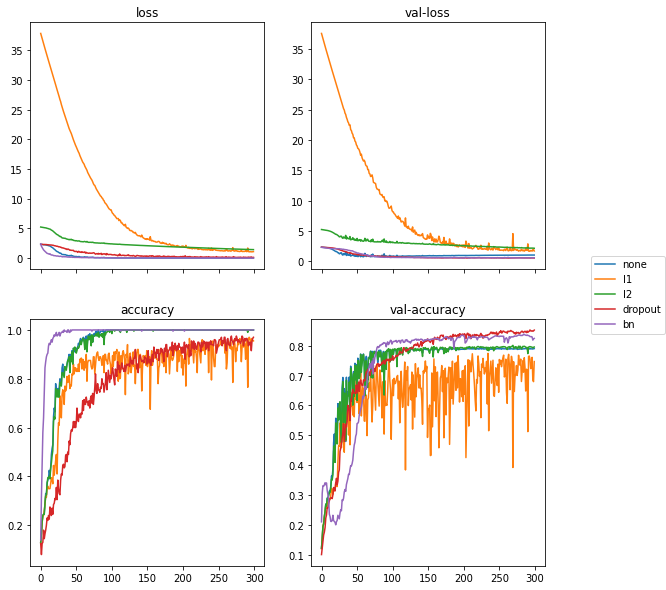

In [30]:
# add parameter `sharey='row'` for a more direct comparison
fig, ax = plt.subplots(2, 2, figsize=(10,10), sharex='col')
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("accuracy")
ax[1, 1].set_title("val-accuracy")

lines, labels = [], []
for config_name in history_per_instance:
    history = history_per_instance[config_name]
    ax[0, 0].plot(history.history['loss'])
    ax[0, 1].plot(history.history['val_loss'])
    ax[1, 0].plot(history.history['accuracy'])
    line = ax[1, 1].plot(history.history['val_accuracy'])
    lines.append(line[0])
    labels.append(config_name)

fig.legend(lines,labels, loc='center right', borderaxespad=0.1)
plt.subplots_adjust(right=0.84)

In [31]:
for config_name in history_per_instance:
    best_val_acc = max(history_per_instance[config_name].history['val_accuracy']) * 100
    print(f'Max val-accuracy for model "{config_name}": {best_val_acc:.2f}%')

Max val-accuracy for model "none": 79.07%
Max val-accuracy for model "l1": 77.41%
Max val-accuracy for model "l2": 80.09%
Max val-accuracy for model "dropout": 85.25%
Max val-accuracy for model "bn": 83.85%
